In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle
import gzip
from matplotlib import rc
from matplotlib.lines import Line2D
import warnings

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [11]:
np.linspace(0, 10, 132) % (2*np.pi)

array([0.        , 0.07633588, 0.15267176, 0.22900763, 0.30534351,
       0.38167939, 0.45801527, 0.53435115, 0.61068702, 0.6870229 ,
       0.76335878, 0.83969466, 0.91603053, 0.99236641, 1.06870229,
       1.14503817, 1.22137405, 1.29770992, 1.3740458 , 1.45038168,
       1.52671756, 1.60305344, 1.67938931, 1.75572519, 1.83206107,
       1.90839695, 1.98473282, 2.0610687 , 2.13740458, 2.21374046,
       2.29007634, 2.36641221, 2.44274809, 2.51908397, 2.59541985,
       2.67175573, 2.7480916 , 2.82442748, 2.90076336, 2.97709924,
       3.05343511, 3.12977099, 3.20610687, 3.28244275, 3.35877863,
       3.4351145 , 3.51145038, 3.58778626, 3.66412214, 3.74045802,
       3.81679389, 3.89312977, 3.96946565, 4.04580153, 4.1221374 ,
       4.19847328, 4.27480916, 4.35114504, 4.42748092, 4.50381679,
       4.58015267, 4.65648855, 4.73282443, 4.80916031, 4.88549618,
       4.96183206, 5.03816794, 5.11450382, 5.19083969, 5.26717557,
       5.34351145, 5.41984733, 5.49618321, 5.57251908, 5.64885

In [10]:
10 % 2*np.pi

0.0

Simulating radial isochron map

In [154]:
def simulating_radial_isochron_map(theta_start, antal_iterationer, Omega, A_ext):
    theta = [theta_start]
    iterationer = np.arange(antal_iterationer + 1)
    
    for i in range(antal_iterationer):
        if i == 0:
            inner = (np.cos(theta[i]) + A_ext) / np.sqrt(1 + 2 * A_ext * np.cos(theta[i]) + A_ext**2)
            next_theta = theta[0] + np.arccos(inner) + 2*Omega*np.pi

        if (theta[i] % (2 * np.pi)) <= np.pi:
            inner = (np.cos(theta[i]) + A_ext) / np.sqrt(1 + 2 * A_ext * np.cos(theta[i]) + A_ext**2)
            next_theta = theta[i-1] + np.arccos(inner) + 2*Omega*np.pi

        elif ((theta[i] % (2 * np.pi)) > np.pi):
            inner = (np.cos(theta[i]) + A_ext) / np.sqrt(1 + 2 * A_ext * np.cos(theta[i]) + A_ext**2)
            next_theta = theta[i-1] + ((2 * np.pi) - np.arccos(inner)) + 2*Omega*np.pi

        theta.append(next_theta)
    return np.array(iterationer), np.array(theta)

In [243]:
ext_rot = 1
int_rot = 3.5

current_omega = ext_rot/int_rot
coupling_strength = 30

iter, sim = simulating_radial_isochron_map(0, 300, current_omega, coupling_strength)


print((sim[-1] % (2*np.pi)) / (2*np.pi*100))

0.008506366861542462


(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6.]),
 array([-4.48827641, -4.42543916, -4.3626019 , -4.29976465, -4.2369274 ,
        -4.17409014, -4.11125289, -4.04841563, -3.98557838, -3.92274112,
        -3.85990387, -3.79706661, -3.73422936, -3.6713921 , -3.60855485,
        -3.5457176 , -3.48288034, -3.42004309, -3.35720583, -3.29436858,
        -3.23153132, -3.16869407, -3.10585681, -3.04301956, -2.9801823 ,
        -2.91734505, -2.8545078 , -2.79167054, -2.72883329, -2.66599603,
        -2.60315878, -2.54032152, -2.47748427, -2.41464701, -2.35180976,
        -2.28897251, -2.22613525, -2.16

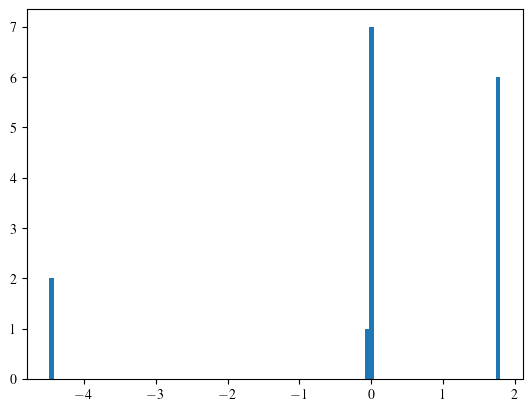

In [244]:
plt.hist(np.diff(sim[-int((5*(int_rot * ext_rot))):] % (2 * np.pi)), bins=100)

In [245]:
circle = np.linspace(0, 2*np.pi, 100)

x = np.cos(sim)
y = np.sin(sim)
n = iter

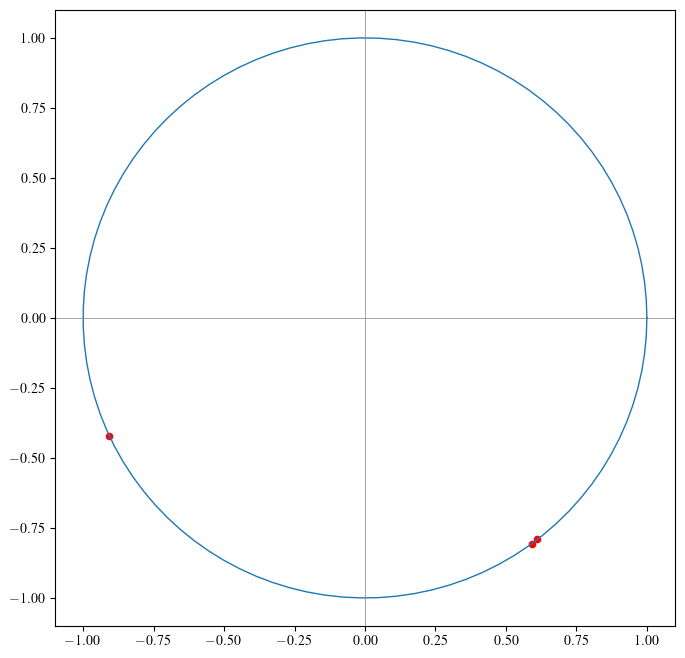

In [247]:
fix, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.cos(circle), np.sin(circle), linewidth=1)
ax.scatter(x[-int((int_rot * ext_rot)):], y[-int((int_rot * ext_rot)):], s=20, color="red")

# for i, txt in enumerate(n):
#     ax.annotate(txt, (x[i], y[i]))


ax.axvline(0, color="grey", lw=0.5)
ax.axhline(0, color="grey", lw=0.5)

In [5]:
def entrainment_radial(omega_list, coupling_list):
    radial_dict = {"Omega": [], "coupling_strength": [], "entrainment_value": [], "exception": []}
    A_int = 1
    A_ext_list = coupling_list * A_int

    for i in tqdm(range(len(omega_list)), desc="Processing"):
        for j in range(len(A_ext_list)):
            antal_iterationer = 400 #svarer til antallet af peaks
            theta_start = 0
            simulation_radial = simulating_radial_isochron_map(theta_start, antal_iterationer, omega_list[i], A_ext_list[j])
            sim_iterationer, sim_theta = simulation_radial[0], simulation_radial[1]

            rotation_number = 0
            exception = False
            
            try:
                rotation_number = sim_theta[-1] / (2*np.pi ) / (antal_iterationer)
            except:
                exception = True
            
            radial_dict["Omega"].append(omega_list[i])
            radial_dict["coupling_strength"].append(coupling_list[j])
            radial_dict["entrainment_value"].append(rotation_number)
            radial_dict["exception"].append(exception)
        
    return radial_dict

In [6]:
antal_omega = 100
antal_coupling = 100

# Der laves gridsearch på disse omega og coupling
omega_list = np.linspace(0,5,antal_omega)
coupling_list = np.linspace(0,2,antal_coupling)

entrainment_sim = entrainment_radial(omega_list, coupling_list)

Processing:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/k7/f1crpym10dq1jlwf0j2n3h080000gn/T/ipykernel_85000/1529514809.py:8: RuntimeWarning: invalid value encountered in arccos
  theta_next = np.arccos(indmad) + 2*np.pi*Omega
Processing: 100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


In [7]:
Omegas_tested = entrainment_sim["Omega"]
Coupling_strengths_tested = entrainment_sim["coupling_strength"]
Entrainments = np.array(entrainment_sim["entrainment_value"])
Exceptions = entrainment_sim["exception"]

threshold = 0.01
tunger = [0, 0.5, 1, 1.5, 2, 2.5, 3] 
tunger_v2 = np.linspace(0.1,3,30)

colors = ['C0', 'C1', 'C2', 'C6', 'C7', 'C8', 'C9']
colors_v2 = ["red", "orange", "blue", "magenta", "green", "cyan", "darkviolet"]
arnold_color_scheme = ["#548687", "#56445D", "#A26769", "#9CB380", "#508AA8", "#C8EAD3", "#31474D", '#DAE0DC']
label = ["0", fr"$\frac{1}{2}$", "1", fr"$\frac{3}{2}$", "2", fr"$\frac{5}{2}$", "3", fr"$n\cdot0.1$"] 

def get_color_map(Entrainments, tunger, threshold, colors):
    color_map = []

    for entrainment in tqdm(Entrainments, "Processing"):
        # Initialize the color to white (default color)
        color = 'white'

        # Check if entrainment falls within any of the specified ranges
        for i, start in enumerate(tunger_v2):
            if start - threshold <= entrainment <= start + threshold:
                color = '#DAE0DC'
                break  # Break out of the loop once a matching range is found

        # Check if entrainment falls within any of the specified ranges
        for i, start in enumerate(tunger):
            if start - threshold <= entrainment <= start + threshold:
                color = arnold_color_scheme[i]
                break  # Break out of the loop once a matching range is found

        color_map.append(color)

    return color_map

color_map = get_color_map(Entrainments, tunger, threshold, colors)

Processing: 100%|██████████| 10000/10000 [00:00<00:00, 394464.73it/s]


Processing: 0it [00:00, ?it/s]


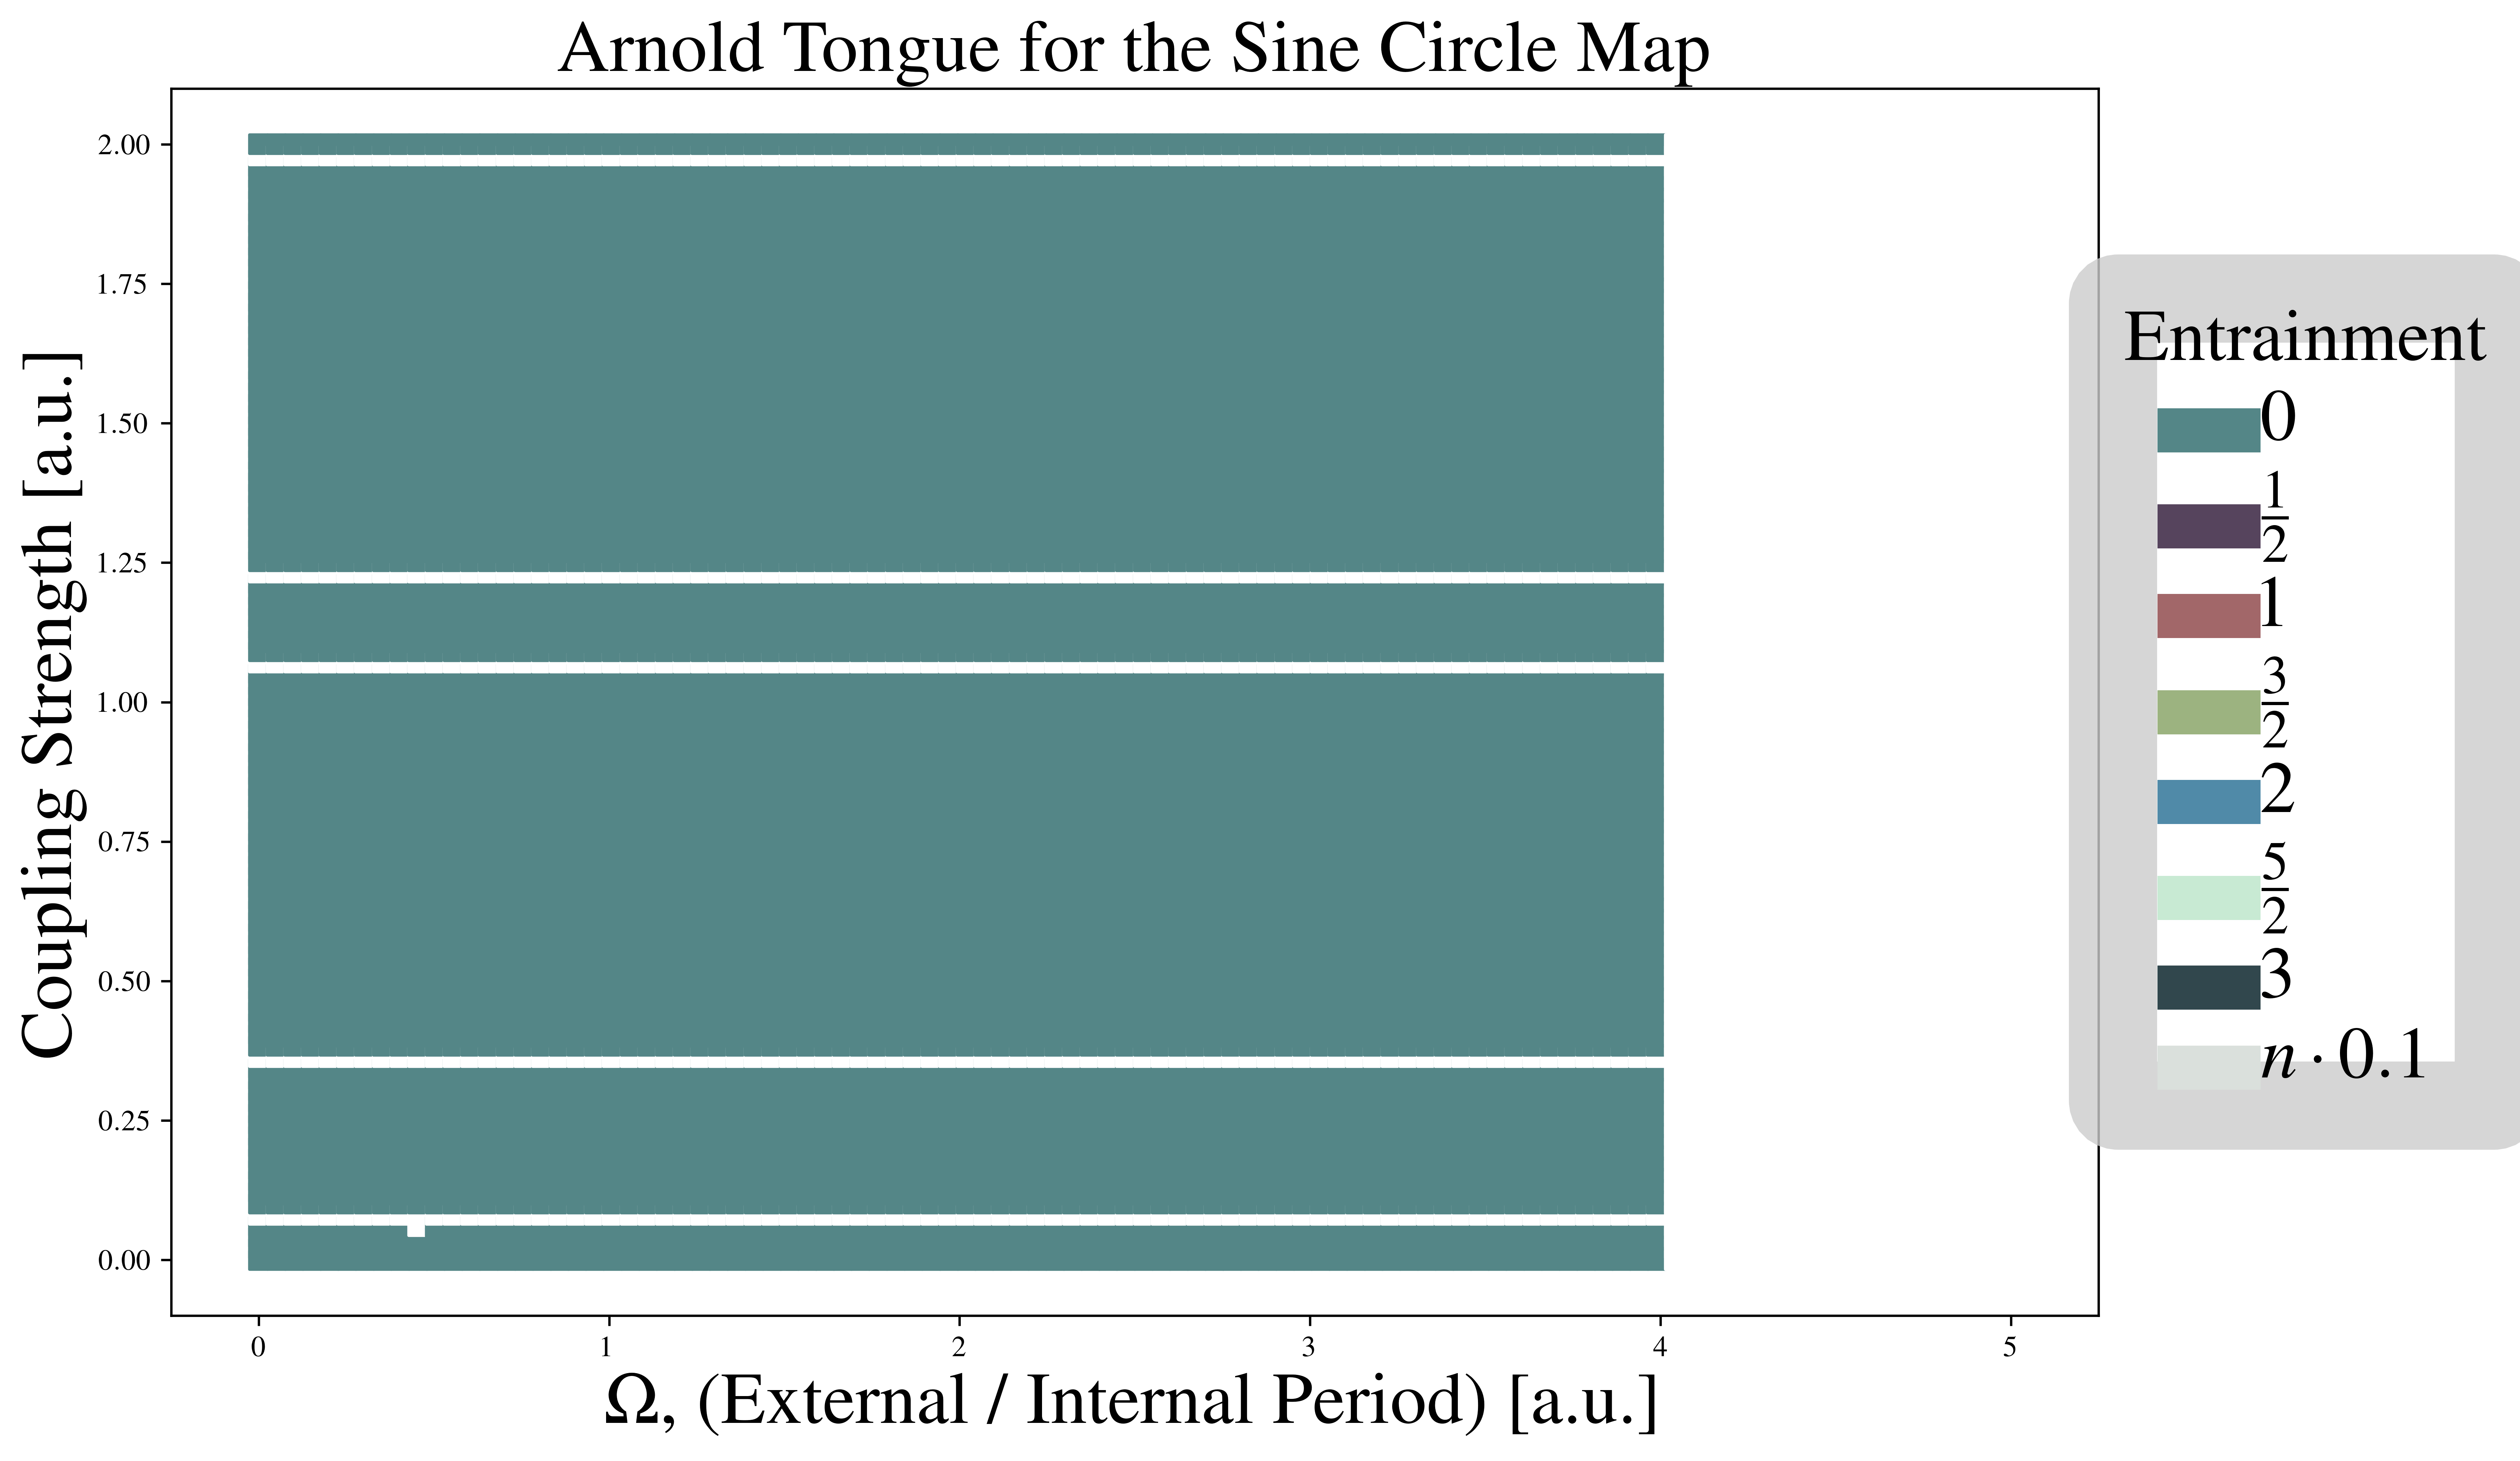

In [8]:
plt.figure(figsize=(11,7), dpi=600)

tqdm(plt.scatter(Omegas_tested, Coupling_strengths_tested, c=color_map, s=40, marker="s"), "Processing")

handles = []
for i in range(len(arnold_color_scheme)):
    line = Line2D([], [], color=arnold_color_scheme[i], lw=15, label=label[i])
    handles.append(line)

plt.title("Arnold Tongue for the Sine Circle Map", fontsize=25)
plt.ylabel("Coupling Strength [a.u.]", fontsize=25)
plt.xlabel(rf"$\Omega$, (External / Internal Period) [a.u.]", fontsize=25)
legend = plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Entrainment')
plt.tight_layout()

legend.legend_handles[0]._sizes = [40]  # Increase marker size for better visibility
legend.get_frame().set_linewidth(30)  # Increase border width
legend.get_title().set_fontsize(25)  # Increase title font size
for text in legend.get_texts():
    text.set_fontsize(25)  # Increase label font size